In [3]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from sklearn.preprocessing import LabelBinarizer, Imputer
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image

# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from Translator import Translator
from preprocessor import define_blocks, extend_data
from visualization import generate_graph_tree


# Add modules path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Define language and translator functions
language = "es"
translator = Translator(language)
to_lang = translator.translate_to_language
to_col = translator.translate_to_column

# Load data
raw_data = pd.read_csv("sample.txt", header=0, skiprows=1, delimiter="\t", index_col=0, usecols=list(range(0, 9)),
                       parse_dates=to_lang(["Datetime"]), decimal=",",
                       date_parser=lambda x: pd.to_datetime(x, format="%Y/%m/%d %H:%M"))
# Translate column names
raw_data.columns = (to_col(raw_data.columns))

# Divide in blocks and extend dataset
data = define_blocks(raw_data)

# Delete rows with no previous meal (Initial values)
data.dropna(inplace='True', subset=['Last_Meal'])

data = extend_data(data)
list(data.columns.values)

['Datetime',
 'Glucose_Auto',
 'Block',
 'Day_Block',
 'Last_Meal',
 'Overlapped_Block',
 'Carbo_Block',
 'Rapid_Insulin_Block',
 'Glucose_Mean_Block',
 'Glucose_Std_Block',
 'Glucose_Min_Block',
 'Glucose_Max_Block',
 'Glucose_Mean_Day',
 'Glucose_Std_Day',
 'Glucose_Min_Day',
 'Glucose_Max_Day',
 'MAGE',
 'Weekday',
 'Minutes_Last_Meal',
 'Diagnosis']

## Removing columns that cannot be passed to the estimator (Datetime and day block)


In [4]:
data = data.drop(["Datetime", "Day_Block", "Last_Meal"], axis=1)

## Binarize labels in a one-vs-all fashion (Hyperglycemia, Hypoglycemia and Normal) to get binary labels

In [5]:
lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
lb.fit(data["Diagnosis"])
labels = pd.DataFrame(index=data.index)
for x in lb.classes_:
    labels[x + "_Diagnosis"] = np.nan 
labels.loc[:, [x + "_Diagnosis" for x in lb.classes_]] = lb.transform(data["Diagnosis"])
data = data.drop("Diagnosis", axis=1)
labels[["Hyperglycemia_Diagnosis", "Hypoglycemia_Diagnosis",
       "Normal_Diagnosis"]].iloc[[1, 200, 400, 600, 800, 1400]]

,Hyperglycemia_Diagnosis,Hypoglycemia_Diagnosis,Normal_Diagnosis
1,0,1,0
200,0,0,1
400,0,0,1
600,0,1,0
800,0,0,1
1400,0,0,1


## Infer NaN entries with mean (No MAGE)

In [6]:
data[pd.isnull(data).any(axis=1)].shape

(59, 16)

In [7]:
mp = Imputer(missing_values='NaN', strategy='mean', axis=0)
mp.fit(data)
data.loc[:, :] = mp.transform(data)

In [8]:
data[pd.isnull(data).any(axis=1)].shape

(0, 16)

# Train decision trees

In [9]:
min_percentage_hyperglycemia = 0.1
min_percentage_hypoglycemia = 0.1
max_impurity = 0.1
min_samples_hyperglycemia = int(min_percentage_hyperglycemia * labels[labels["Hyperglycemia_Diagnosis"] == 1].shape[0])
min_samples_hypoglycemia = int(min_percentage_hyperglycemia * labels[labels["Hypoglycemia_Diagnosis"] == 1].shape[0])


model_hyperglycemia = DecisionTreeClassifier(criterion='gini', splitter='best',
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=min_samples_hyperglycemia,
                              min_weight_fraction_leaf=0.0,
                              max_features=None,
                              random_state=None,
                              max_leaf_nodes=None,
                              min_impurity_split=1e-07,
                              class_weight=None,
                              presort=True)
model_hypoglycemia = DecisionTreeClassifier(criterion='gini', splitter='best',
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=min_samples_hypoglycemia,
                              min_weight_fraction_leaf=0.0,
                              max_features=None,
                              random_state=None,
                              max_leaf_nodes=None,
                              min_impurity_split=1e-07,
                              class_weight=None,
                              presort=True)

In [10]:
model_hyperglycemia = model_hyperglycemia.fit(data, labels["Hyperglycemia_Diagnosis"])
model_hypoglycemia = model_hypoglycemia.fit(data, labels["Hypoglycemia_Diagnosis"])

## Visualize the decision trees

### Hyperglycemia model

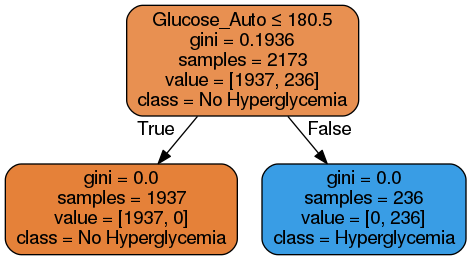

In [11]:
graph = generate_graph_tree(model_hyperglycemia, data.columns, ['No Hyperglycemia', 'Hyperglycemia'])
Image(graph.create_png())

### Hypoglycemia model


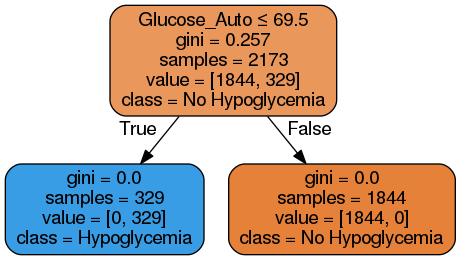

In [12]:
graph = generate_graph_tree(model_hypoglycemia, data.columns, ['No Hypoglycemia', 'Hypoglycemia'])
Image(graph.create_png())

Splits are well done with 0 entropy as there exist a dependency between the column Glucose_Auto and the label.
It is neccessary to use information that allow to discover patterns that are not related only to the glucose level

## Remove Glucose_Auto column

In [13]:
data = data.drop("Glucose_Auto", axis=1)
model_hyperglycemia = model_hyperglycemia.fit(data, labels["Hyperglycemia_Diagnosis"])
model_hypoglycemia = model_hypoglycemia.fit(data, labels["Hypoglycemia_Diagnosis"])

### Hyperglycemia model

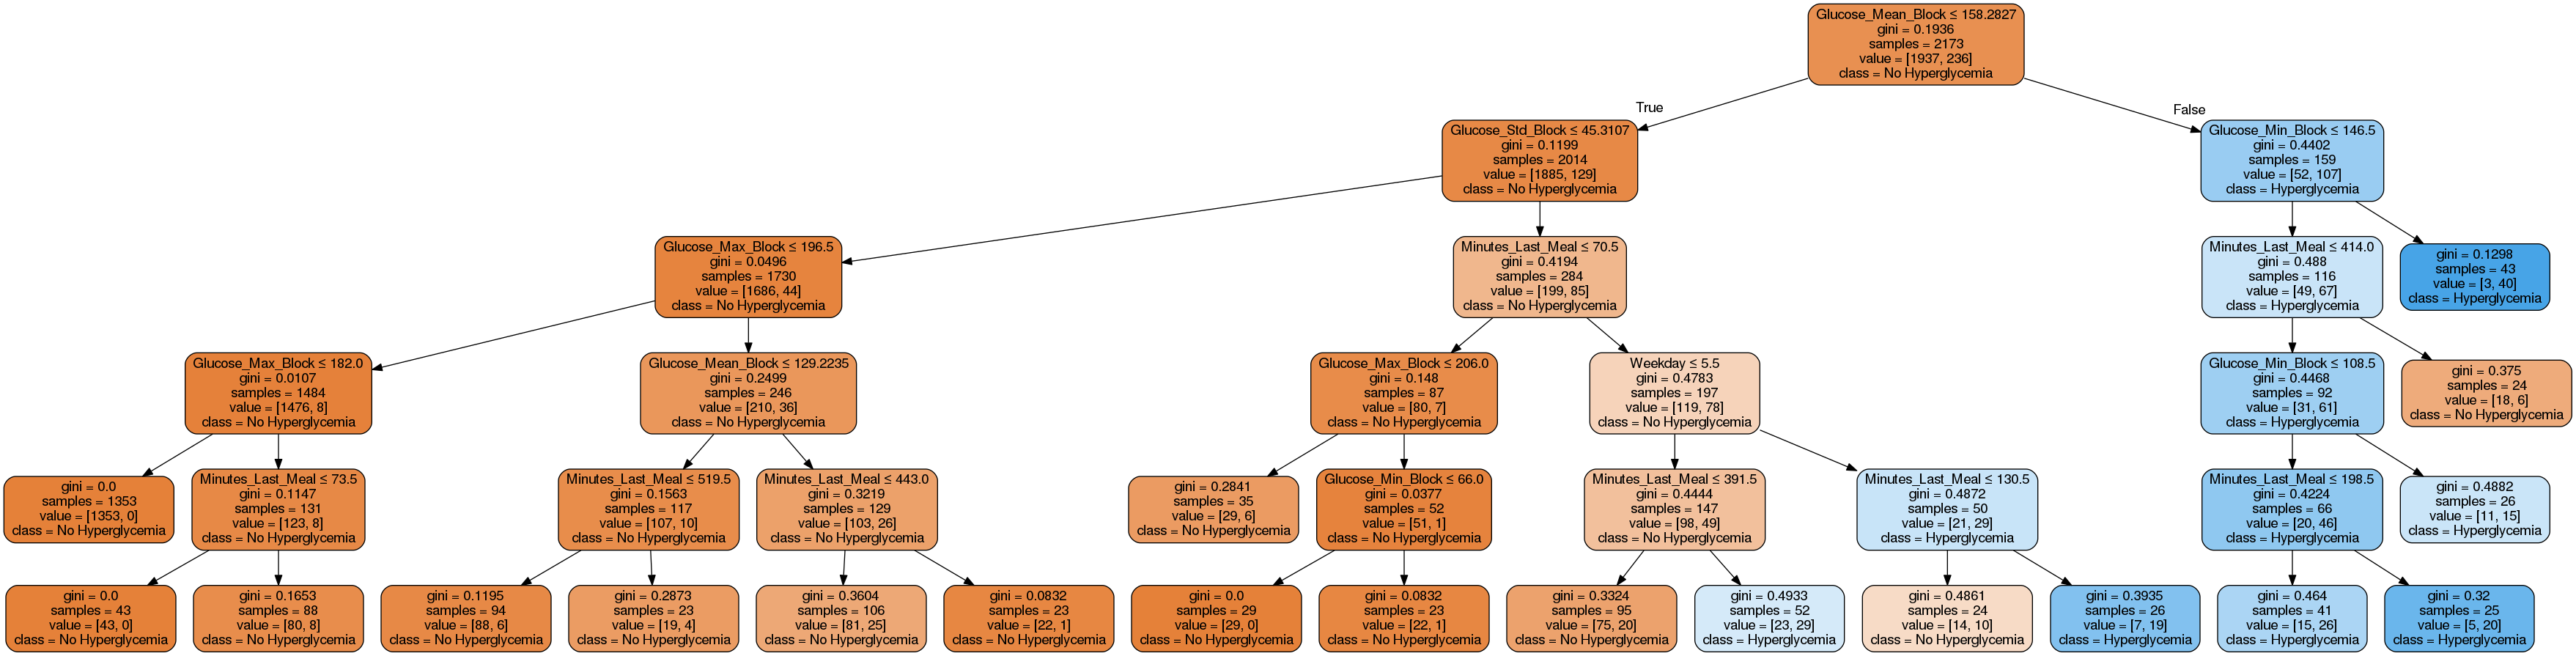

In [14]:
graph = generate_graph_tree(model_hyperglycemia, data.columns, ['No Hyperglycemia', 'Hyperglycemia'])
Image(graph.create_png())

### Hypoglycemia model

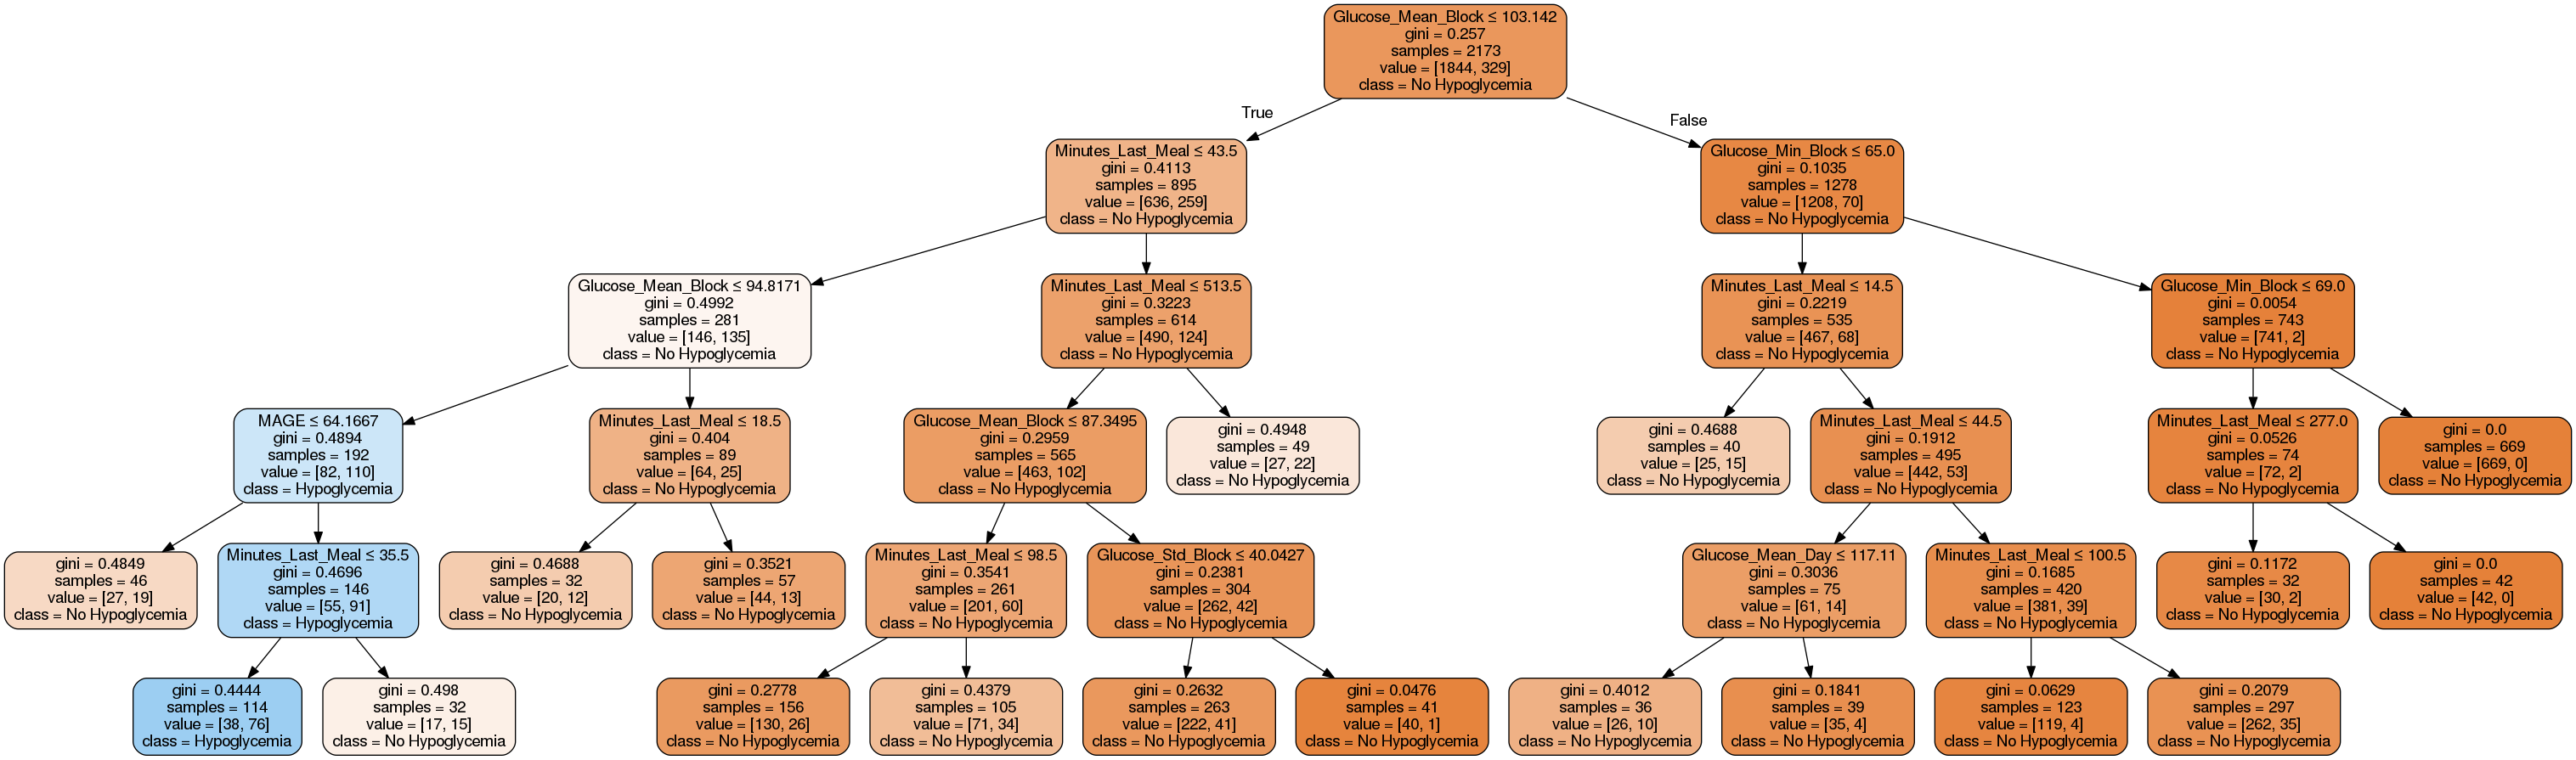

In [15]:
graph = generate_graph_tree(model_hypoglycemia, data.columns, ['No Hypoglycemia', 'Hypoglycemia'])
Image(graph.create_png())

# Feature importance

In [16]:
print("Hyperglycemia feature importance")
for idx, score in enumerate(model_hyperglycemia.feature_importances_):
    print("{:s} : {:.4f} ".format(data.columns[idx], score))

Hyperglycemia feature importance
Block : 0.0000 
Overlapped_Block : 0.0000 
Carbo_Block : 0.0000 
Rapid_Insulin_Block : 0.0000 
Glucose_Mean_Block : 0.5466 
Glucose_Std_Block : 0.1803 
Glucose_Min_Block : 0.0413 
Glucose_Max_Block : 0.0505 
Glucose_Mean_Day : 0.0000 
Glucose_Std_Day : 0.0000 
Glucose_Min_Day : 0.0000 
Glucose_Max_Day : 0.0000 
MAGE : 0.0000 
Weekday : 0.0224 
Minutes_Last_Meal : 0.1589 


In [17]:
print("Hypoglycemia feature importance")
for idx, score in enumerate(model_hypoglycemia.feature_importances_):
    print("{:s} : {:.4f} ".format(data.columns[idx], score))

Hypoglycemia feature importance
Block : 0.0000 
Overlapped_Block : 0.0000 
Carbo_Block : 0.0000 
Rapid_Insulin_Block : 0.0000 
Glucose_Mean_Block : 0.5195 
Glucose_Std_Block : 0.0090 
Glucose_Min_Block : 0.0715 
Glucose_Max_Block : 0.0000 
Glucose_Mean_Day : 0.0084 
Glucose_Std_Day : 0.0000 
Glucose_Min_Day : 0.0000 
Glucose_Max_Day : 0.0000 
MAGE : 0.0227 
Weekday : 0.0000 
Minutes_Last_Meal : 0.3688 


In [18]:
plt.figure()
target_names = ['No Hyperglycemia', 'Hyperglycemia']
for i, color in zip(range(2), 'br'):
    plt.scatter(data[labels["Hyperglycemia_Diagnosis"] == i]["Glucose_Mean_Block"],
                data[labels["Hyperglycemia_Diagnosis"] == i]["Minutes_Last_Meal"], c=color, label=target_names[i],
                cmap=plt.get_cmap('Paired'))

plt.xlabel("Glucose_Mean_Block")
plt.ylabel("Minutes_Last_Meal")
plt.axis("tight")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<div id='faf0ba6b-0bde-47db-9af5-d82f858db9f4'></div>

In [19]:
plt.figure()
target_names = ['No Hypoglycemia', 'Hypoglycemia']
for i, color in zip(range(2), 'br'):
    plt.scatter(data[labels["Hypoglycemia_Diagnosis"] == i]["Glucose_Mean_Block"],
                data[labels["Hypoglycemia_Diagnosis"] == i]["Minutes_Last_Meal"], c=color, label=target_names[i],
                cmap=plt.get_cmap('Paired'))

plt.xlabel("Glucose_Mean_Block")
plt.ylabel("Minutes_Last_Meal")
plt.axis("tight")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<div id='c08a4b54-f9bf-48b8-8f6a-ff2aab7a3698'></div>

### Glucose mean of the block and MAGE

In [20]:
plt.figure()
target_names = ['No Hypoglycemia', 'Hypoglycemia']
for i, color in zip(range(2), 'br'):
    plt.scatter(data[labels["Hypoglycemia_Diagnosis"] == i]["Glucose_Mean_Block"],
                data[labels["Hypoglycemia_Diagnosis"] == i]["MAGE"], c=color, label=target_names[i],
                cmap=plt.get_cmap('Paired'))

plt.xlabel("Glucose_Mean_Block")
plt.ylabel("MAGE")
plt.axis("tight")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<div id='c28ae5f9-ca5a-422a-934e-20bb1d576471'></div>

In [20]:
plt.figure()
target_names = ['No Hyperglycemia', 'Hyperglycemia']
for i, color in zip(range(2), 'br'):
    plt.scatter(data[labels["Hyperglycemia_Diagnosis"] == i]["Glucose_Mean_Block"],
                data[labels["Hyperglycemia_Diagnosis"] == i]["MAGE"], c=color, label=target_names[i],
                cmap=plt.get_cmap('Paired'))

plt.xlabel("Glucose_Mean_Block")
plt.ylabel("MAGE")
plt.axis("tight")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<div id='0753fc83-2255-444a-b2bf-6a05897b962b'></div>

Conclusions:
- Glucose_Mean_Block is strongly correlated with the both labels. 
- Minutes_Last_Meal is slightly correlated with Hypoglycemia
- MAGE does not influence in the decision making